# Bike Sharing Prediction

![title](images/bikes.png)

<br>

## Table of contents
[1. Context and objective](#section1)

[2. Exploring the datasets (EDA)](#section2)

* [A. TL;DR](##section2A)
* [B. Structure of the datasets](##section2B)
* [C. Adding new variables](##section2C)
* [D. Visualisation](##section2D)

[3. Prediction](#section3)
* [A. Preparing the training dataset](##section3A)
* [B. Selecting the models](##section3B)
* [C. Hyper tuning final models](##section3C)

<br>

<a id="Section1"></a>
## 1. Context and objective

This notebook is our final project for the class [MAP546P - Python for Data Science](https://moodle.polytechnique.fr/course/view.php?id=6124).

The objective is to **forecast the use of the city bikeshare system** in Washington. It is part of a [Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand#description).

<a id="Section2"></a>
## 2. Exploring the datasets (EDA)
<a id="Section2A"></a>
### A. TL;DR

<a id="Section2B"></a>
### B. Structure of the datasets

In [129]:
# Removing FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing libraries
import pandas as pd
import numpy as np
import datetime
from math import cos, pi
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, ParameterGrid
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
import xgboost as xg

In [ ]:
# Importing datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Merging datasets
train["is_train"] = [1 for x in range(train.shape[0])]
test["is_train"] = [0 for x in range(test.shape[0])]
datasets = pd.concat([train, test], sort=False)
datasets = datasets.reset_index(drop = True)

In [97]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.0
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,1.0
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.0
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,1.0
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,1.0
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,1.0
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,1.0


The **training** dataset has **~11k rows**, and **12 columns**:
- **<font color='grey'>datetime</font>** - hourly date + timestamp (from 2011-01-01 to 2012-12-19)
- **<font color='grey'>season</font>**
    -  1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter 
- **<font color='grey'>holiday</font>** - whether the day is considered a holiday
- **<font color='grey'>workingday</font>** - whether the day is neither a weekend nor holiday
- **<font color='grey'>weather</font>** 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- **<font color='grey'>temp</font>** - temperature in Celsius (from 0.82 to 40)
- **<font color='grey'>atemp</font>** - "feels like" temperature in Celsius (from 0.76 to 45.45)
- **<font color='grey'>humidity</font>** - relative humidity (from 0% to 100%)
- **<font color='grey'>windspeed</font>** - wind speed (from 0 to 57)
- **<font color='grey'>casual</font>** - number of non-registered user rentals initiated (from 0 to 367)
- **<font color='grey'>registered</font>** - number of registered user rentals initiated (from 0 to 886)
- **<font color='grey'>count</font>** - number of total rentals (from 1 to 977)

In [98]:
test.shape

(6493, 10)

The **test** dataset has **~6k** rows.

In [99]:
pd.DataFrame(data=datasets.isna().sum(), columns=["Number of NAs"]).transpose()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
Number of NAs,0,0,0,0,0,0,0,0,0,6493,6493,6493,0


Neither the training nor the test dataset has **missing entries**.

<a id="Section2C"></a>
### C. Adding new variables

In [100]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1


We can create new variables from ```datetime```.

In [101]:
# Creating new variables from datetime
datasets["year"] = [int(datasets.datetime[x][0:4]) for x in range(datasets.shape[0])]
datasets["month"] = [int(datasets.datetime[x][5:7]) for x in range(datasets.shape[0])]
datasets["day"] = [int(datasets.datetime[x][8:10]) for x in range(datasets.shape[0])]
datasets["hour"] = [int(datasets.datetime[x][11:13]) for x in range(datasets.shape[0])]
datasets["weekday"] = [datetime.datetime.strptime(datasets.datetime[x][0:10], '%Y-%m-%d').weekday() for x in range(datasets.shape[0])]
datasets["date"] = [datetime.datetime.strptime(datasets.datetime[x][0:10], '%Y-%m-%d') for x in range(datasets.shape[0])]
datasets["dayoverall"] = [(datasets.date[x].date() - datetime.date(2011,1,1)).days for x in range(datasets.shape[0])]
datasets["weeknumber"] = [datasets.date[x].isocalendar()[1] for x in range(datasets.shape[0])]
datasets["monthyear"] = datasets.date.dt.to_period('M')

If needed, we could also create categorical variables from the continuous variables ```temp```, ```atemp```, ```humidity```, and ```windspeed```. This would be useful if these variables had little correlation with our target variable ```count```, and if the resulting categories were correlated with ```count```. Let's thus see if we should do it.

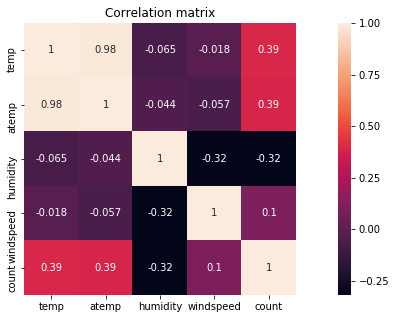

In [102]:
# Computing the correlation matrix
corrMatrix = train[["temp","atemp","humidity","windspeed","count"]].corr()

# Plotting the correlation matrix
fig,ax = plt.subplots(figsize=(15,5))
sn.heatmap(corrMatrix, square=True,annot=True)
plt.title("Correlation matrix")
plt.show()

One can observe that the variable ```windspeed``` has little correlation with ```count``` (corr = 0.1). This suggests that we should not include it in our model (but instead, we will consider transforming it into categories).

On the other hand, ```temp``` (corr = 0.39), ```atemp``` (corr = 0.39) and ```humidity``` (corr = -0.32) are quite correlated with our target variable. But given the strong correlation between ```temp``` and ```atemp``` (0.98), we should only keep one of these two.

In [103]:
# Creating new variables from windspeed, temp and atemp
datasets["tempminusatemp"] = [-1 if (datasets.atemp[x] - datasets.temp[x]) < 0
                              else 1 if (datasets.atemp[x] - datasets.temp[x]) > 3.7
                              else float('nan') for x in range(datasets.shape[0])]
datasets["tempcategory"] = [0 if datasets.temp[x] < 13.5
                            else 1 if datasets.temp[x] < 20
                            else 2 if datasets.temp[x] < 27
                            else 3 for x in range(datasets.shape[0])]
datasets["humiditycategory"] = [0 if datasets.humidity[x] < 47
                                else 1 if datasets.humidity[x] < 78
                                else 2 for x in range(datasets.shape[0])]

In [104]:
train = datasets[datasets.is_train == 1]
test = datasets[datasets.is_train == 0]

Now, let's see if we should keep our new categorical variables.

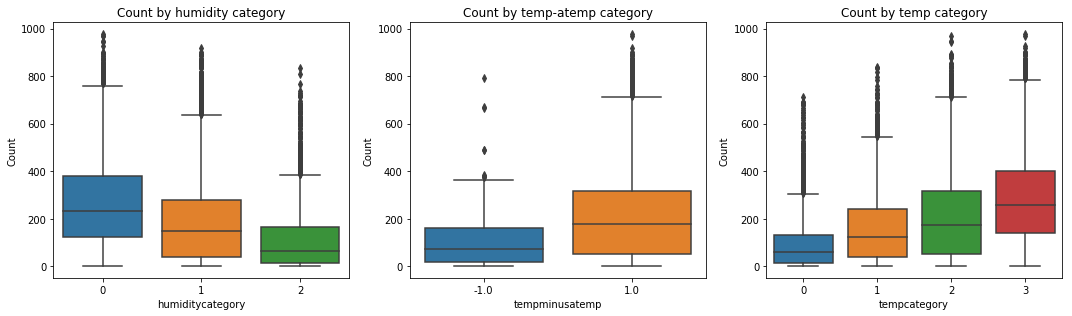

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 4.5)

sn.boxplot(data=train, y="count", x="humiditycategory", orient="v", ax=axes[0])
axes[0].set(ylabel='Count', title="Count by humidity category")

sn.boxplot(data=train, y="count", x="tempcategory", orient="v", ax=axes[2])
axes[2].set(ylabel='Count', title="Count by temp category")

sn.boxplot(data=train, y="count", x="tempminusatemp", orient="v", ax=axes[1])
axes[1].set(ylabel='Count', title="Count by temp-atemp category")

plt.tight_layout()

The average number of rentals differ depending on the humidity, temp and temp-atemp categories. This is a good sign: the new variables explain part of the variations of ```count```. We can thus integrate them in our model.

<a id="Section2D"></a>
### D. Analyzing the response variable

Let's see how the response variable behaves.

In [ ]:
fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(15,5))

sn.distplot(train['count'], ax=axes[0])
axes[0].set(title="Distribution of count")

sn.distplot(train['registered'], ax=axes[1])
axes[1].set(title="Distribution of registered")

sn.distplot(train['casual'], ax=axes[2])
axes[2].set(title="Distribution of casual")

plt.tight_layout()

<font color='red'>Réaliser les 3 plots + rédiger leurs commentaires (skewed -> we will log-transform them)</font>

Instead of predicting the variable ```count```, we could predict separately ```casual``` and ```registered```, and add their predictions to obtain ```count```. This would be useful if their behaviors were dissimilar and if they needed to be modelled differently. Let's see what we should do.

In [110]:
# Aggregating values daily, weekly and monthly
aggregationDate = train[train.date].groupby("date")["casual", "registered"].sum().reset_index().melt(id_vars=["date"])
aggregationWeek = train.groupby("weeknumber")["casual", "registered"].sum().reset_index().melt(id_vars=["weeknumber"])
aggregationMonth = train.groupby("monthyear")["casual", "registered"].sum().reset_index().melt(id_vars=["monthyear"])
aggregationMonth.monthyear = [aggregationMonth.monthyear[x].to_timestamp() for x in range(aggregationMonth.shape[0])]

# Displaying values
fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(15,5))

sn.lineplot(data=aggregationDate, x="date", y="value", hue="variable", hue_order=["casual", "registered"], ax=axes[0])
axes[0].set(xlabel='Date', ylabel='Users count',title="Daily number of rentals")

sn.lineplot(data=aggregationWeek, x="weeknumber", y="value", hue="variable", hue_order=["casual", "registered"], ax=axes[1])
axes[1].set(xlabel='Week number', ylabel='Users count',title="Weekly number of rentals")

sn.lineplot(data=aggregationMonth, x="monthyear", y="value", hue="variable", hue_order=["casual", "registered"], ax=axes[2])
axes[2].set(xlabel='Date', ylabel='Users count',title="Monthly number of rentals")

plt.tight_layout()

KeyError: "['2011-01-01T00:00:00.000000000' '2011-01-01T00:00:00.000000000'\n '2011-01-01T00:00:00.000000000' ... '2012-12-19T00:00:00.000000000'\n '2012-12-19T00:00:00.000000000' '2012-12-19T00:00:00.000000000'] not in index"

<font color="red">Corriger cette erreur </font>

We can see that the two variables are behaving similarly at the month level (increasing), but quite differently at lower levels (on the same day, casual can pike up while registered pikes down for instance).

This indicates that **we should consider building two separate models**.

<br>
Last, let's see what is the influence of the season, the weather, the weekday and the user type on the total number of rentals.

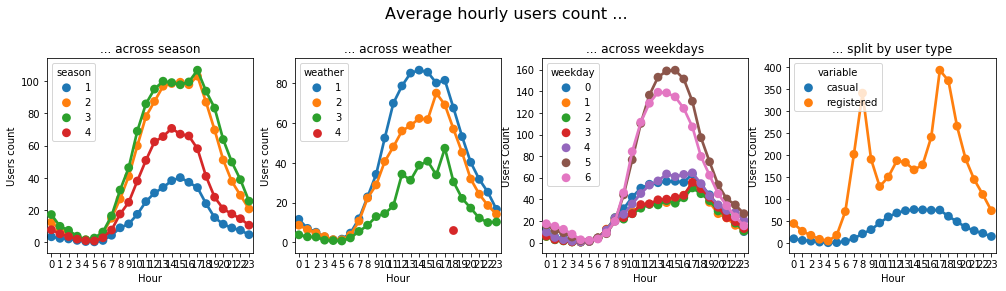

In [111]:
# Displaying the number of rentals
fig, ax= plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(17,4)
fig.suptitle('Average hourly users count ...', fontsize=16)

hourAggregated = pd.DataFrame(train.groupby(["hour","season"],sort=True)["casual"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["casual"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax[0])
ax[0].set(xlabel='Hour', ylabel='Users count',title="... across season", label='big')

hourAggregated = pd.DataFrame(train.groupby(["hour","weather"],sort=True)["casual"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["casual"],hue=hourAggregated["weather"], data=hourAggregated, join=True,ax=ax[1])
ax[1].set(xlabel='Hour', ylabel='Users count',title="... across weather", label='big')

hourAggregated = pd.DataFrame(train.groupby(["hour","weekday"],sort=True)["casual"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["casual"],hue=hourAggregated["weekday"], data=hourAggregated, join=True,ax=ax[2])
ax[2].set(xlabel='Hour', ylabel='Users Count',title="... across weekdays",label='big')

hourTransformed = pd.melt(train[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax[3])
ax[3].set(xlabel='Hour', ylabel='Users Count',title="... split by user type",label='big')

fig.subplots_adjust(top=0.8)

<font color='red'>Rédiger les commentaires de ces graphes</font>

Takeaways:
- The shapes of the cycles vary with the season (the bell is flatter in spring (season = 1)) and the weekday (the bell is sharper on week-ends).
- Again, we observe a completely different pattern for casual vs registered users. The last plot also shows that registered users are mostly people using the bikes for commuting.

<a id="Section2E"></a>
### E. Analyzing outliers

Before moving on to the model, we need to analyze potential outliers.

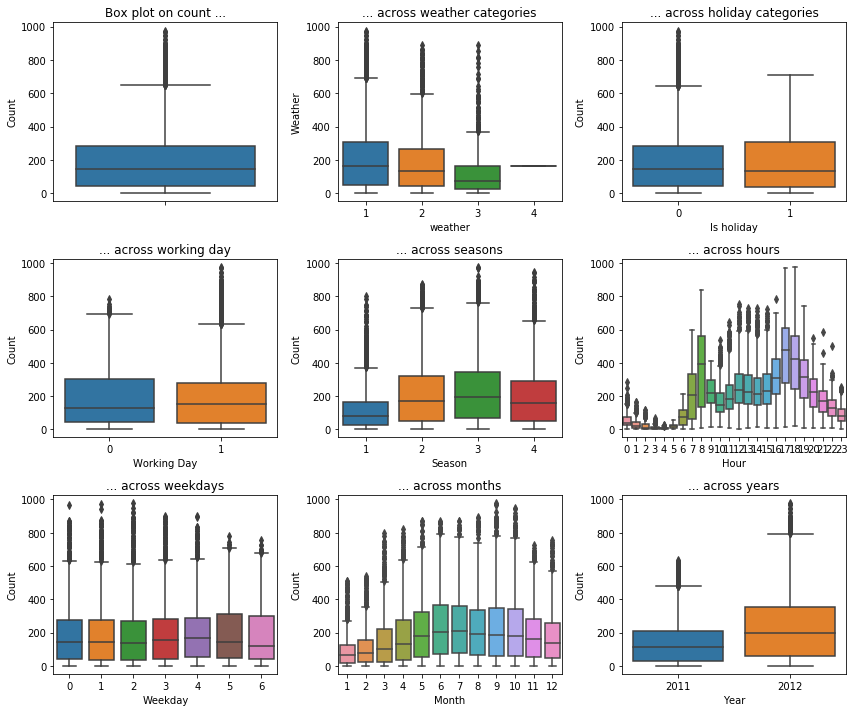

In [112]:
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(12, 10)


# Are there outliers?
sn.boxplot(data=train, y="count", orient="v", ax=axes[0][0])
axes[0][0].set(ylabel='Count', title="Box plot on count ...")


# Who are these outliers? 
sn.boxplot(data=train, y="count", x="weather", orient="v", ax=axes[0][1])
axes[0][1].set(ylabel='Weather', title="... across weather categories")

sn.boxplot(data=train, y="count", x="holiday", orient="v", ax=axes[0][2])
axes[0][2].set(xlabel='Is holiday', ylabel='Count', title="... across holiday categories")

sn.boxplot(data=train,  y="count", x="workingday" ,orient="v", ax=axes[1][0])
axes[1][0].set(xlabel='Working Day', ylabel='Count', title="... across working day")

sn.boxplot(data=train, y="count", x="season", orient="v",ax=axes[1][1])
axes[1][1].set(xlabel='Season', ylabel='Count', title="... across seasons")

sn.boxplot(data=train, y="count", x="hour", orient="v", ax=axes[1][2])
axes[1][2].set(xlabel='Hour', ylabel='Count', title="... across hours")

sn.boxplot(data=train, y="count", x="weekday", orient="v", ax=axes[2][0])
axes[2][0].set(xlabel='Weekday', ylabel='Count', title="... across weekdays")

sn.boxplot(data=train, y="count", x="month", orient="v", ax=axes[2][1])
axes[2][1].set(xlabel='Month', ylabel='Count', title="... across months")

sn.boxplot(data=train,y="count",x="year",orient="v",ax=axes[2][2])
axes[2][2].set(xlabel='Year', ylabel='Count',title="... across years")

plt.tight_layout()

**One can observe (high) outliers in the distribution of the ```count``` variable** (1st plot). They skew its distribution towards right.

The other plots help us investigating these outliers:
- They happen on the days when people work (that is, not during the week-ends nor the holidays)
- But not at the hours when they commute (that is, not from 6am to 9am nor from 4pm to 6pm) 

This indicates that these bikes are primarily used for work commute.

It is also interesting to notice that outliers are independent from the weather, the seasons or the months. For this reason, **we decide to keep them in the model**.

<a id="Section3"></a>
## Prediction

<a id="Section3A"></a>
### A. Preparing the training dataset

During the explanatory data analysis, we draw conclusions on the dataset:
- We should keep outliers
- We should log-transform the response variable
- We should drop some features, such as ```datetime```, ```day```, ```humidity```, ```windspeed``` etc.

Let's thus first implement these changes.

In [116]:
# Merging the datasets
datasetsFinal = pd.concat([train, test], sort=False)

# Removing features
droppingFeatures = ["date", "humidity", "windspeed", "dayoverall", "weeknumber", "weekday", "monthyear", "temp", "atemp"]
datasetsFinal = datasetsFinal.drop(droppingFeatures, axis = 1)
datasetsFinal.head()

,datetime,season,holiday,workingday,weather,casual,registered,count,is_train,year,month,day,hour,tempminusatemp,tempcategory,humiditycategory
0,2011-01-01 00:00:00,1,0,0,1,3.0,13.0,16.0,1,2011,1,1,0,1.0,0,2
1,2011-01-01 01:00:00,1,0,0,1,8.0,32.0,40.0,1,2011,1,1,1,1.0,0,2
2,2011-01-01 02:00:00,1,0,0,1,5.0,27.0,32.0,1,2011,1,1,2,1.0,0,2
3,2011-01-01 03:00:00,1,0,0,1,3.0,10.0,13.0,1,2011,1,1,3,1.0,0,1
4,2011-01-01 04:00:00,1,0,0,1,0.0,1.0,1.0,1,2011,1,1,4,1.0,0,1


In [117]:
# Getting dummies
categoricalFeatures = ["season", "holiday", "workingday", "weather", "tempminusatemp", 
                       "tempcategory", "humiditycategory"]
datasetsFinal = pd.get_dummies(datasetsFinal, columns = categoricalFeatures)


# Splitting training and test sets
trainFinal = datasetsFinal[datasetsFinal.is_train == 1].drop(columns=["is_train", "datetime"])
testFinal = datasetsFinal[datasetsFinal.is_train == 0].drop(columns="is_train")

trainFinal.head()

,casual,registered,count,year,month,day,hour,season_1,season_2,season_3,...,weather_4,tempminusatemp_-1.0,tempminusatemp_1.0,tempcategory_0,tempcategory_1,tempcategory_2,tempcategory_3,humiditycategory_0,humiditycategory_1,humiditycategory_2
0,3.0,13.0,16.0,2011,1,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,1
1,8.0,32.0,40.0,2011,1,1,1,1,0,0,...,0,0,1,1,0,0,0,0,0,1
2,5.0,27.0,32.0,2011,1,1,2,1,0,0,...,0,0,1,1,0,0,0,0,0,1
3,3.0,10.0,13.0,2011,1,1,3,1,0,0,...,0,0,1,1,0,0,0,0,1,0
4,0.0,1.0,1.0,2011,1,1,4,1,0,0,...,0,0,1,1,0,0,0,0,1,0


We now have 25 response variables.

Note that we have made the choice not to consider the variables ```year```, ```month```, ```day```, ```hour```, as categorical variables. But we are aware that this decision could be challenged.

In [192]:
# Preparing the test dataset and the predictions file
predictions = testFinal[["datetime", "casual", "registered", "count"]]
testFinal = testFinal.drop(["casual", "registered", "count", "datetime"], axis = 1)

<a id="Section3B"></a>
### B. Selecting the models

We are going to adopt three distinct strategies to predict the number of rentals:
1. Predicting the variable ```count```
2. Predicting the variables ```casual``` and ```registered``` with the same model and summing them up
3. Predicting the variables ```casual``` and ```registered``` with a distinct model for each and summing them up

For each one of these strategies, we will compare several ML algorithms: ```LinearRegression```,```RandomForestRegressor```,```AdaBoostRegressor```,```BaggingRegressor```,```SVR```,```KNeighborsRegressor```, ```Ridge``` and ```XGBRegressor```. 

For comparing the performances of the models and of the strategies, we will compute and use their ```RMSLE```.

#### Strategy 1: Predicting ```count```

<u>**Identifying the best model**</u>

In [156]:
# Separating into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(trainFinal.drop(['count', 'registered', 'casual'],axis=1),
                                                    trainFinal['count'],
                                                    test_size=0.20,
                                                    random_state=42)

In [84]:
# Listing the models we will try
models = [RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(), Ridge(), xg.XGBRegressor()]
modelLinear= LinearRegression()
model_names = ['LinearRegression','RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor', 'Ridge', 'XGBRegressor']
rmsleStrat1 = []

# Log-transforming the response variable
y_trainLog = np.log1p(y_train)

# Fitting the linear regression separately
modelLinear.fit(x_train, y_trainLog)
predLinear = modelLinear.predict(x_test)
rmsleStrat1.append(np.sqrt(mean_squared_log_error(np.expm1(predLinear), y_test)))

for model in range(len(models)):
    clf = models[model]
    clf.fit(x_train, y_trainLog)
    pred = clf.predict(x_test)
    rmsleStrat1.append(np.sqrt(mean_squared_log_error(np.expm1(pred), y_test)))


In [207]:
# Displaying the results of this strategy
strat1 = pd.DataFrame({'Modelling Algo': model_names,'RMSLE': [round(x,3) for x in rmsleStrat1]}).sort_values(by=["Modelling Algo"])
strat1["Rank"] = strat1["RMSLE"].rank().astype(int)
strat1.sort_values(by=["Rank"])

,Modelling Algo,RMSLE,Rank
3,BaggingRegressor,0.349,1
1,RandomForestRegressor,0.352,2
7,XGBRegressor,0.384,3
4,SVR,0.398,4
5,KNeighborsRegressor,0.480,5
2,AdaBoostRegressor,0.672,6
0,LinearRegression,1.023,7
6,Ridge,1.023,7


The top three algorithms are thus **BaggingRegressor**, **RandomForestRegressor** and **XGBRegressor**. We have decided to focus on XGB.

<br>

<u>**Hyper tuning XGB**</u>

In [176]:
# Separating into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(trainFinal.drop(['count', 'registered', 'casual'],axis=1),
                                                    trainFinal['count'],
                                                    test_size=0.20,
                                                    random_state=42)

# Formatting the training sets
train_array = np.array(x_train)
target_array = np.array(y_train)

# Spliting the train dataset into 3 folds
kfold = KFold(n_splits = 3)
kfold.get_n_splits(train_array)

# Creating the sets of parameters to test
early_stopping = 50
best_score = 10
param_grid = [
              {'silent': [1],
               'nthread': [2],
               'eval_metric': ['rmse'],
               'eta': [0.03],
               'objective': ['reg:linear'],
               'max_depth': [5, 7],
               'num_round': [1000],
               'subsample': [0.2, 0.4, 0.6],
               'colsample_bytree': [0.3, 0.5, 0.7],
               }
              ]


# Computing RMSLE for every set of parameter
for params in ParameterGrid(param_grid):
    print(params)
    
    ## 1. Determine best n_rounds
    xgoost_rounds = []
    for train_index, test_index in kfold.split(train_array):
        X_train, X_test = train_array[train_index], train_array[test_index]
        y_train, y_test = target_array[train_index], target_array[test_index]

        xg_train = xg.DMatrix(X_train, label=y_train)
        xg_test = xg.DMatrix(X_test, label=y_test)

        watchlist = [(xg_train, 'train'), (xg_test, 'test')]
        num_round = params['num_round']
        
        xgregressor = xg.train(params, xg_train, num_round, watchlist,early_stopping_rounds = early_stopping, verbose_eval = False);
        
        xgoost_rounds.append(xgregressor.best_iteration)

    num_round = int(np.mean(xgoost_rounds))
    print('The best n_rounds is %d' % num_round)
    
    ## 2. Compute RMSLE
    rmsle_score = []
    for cv_train_index, cv_test_index in kfold.split(train_array):
        X_train, X_test = train_array[cv_train_index, :], train_array[cv_test_index, :]
        y_train, y_test = target_array[cv_train_index], target_array[cv_test_index]

        xg_train = xg.DMatrix(X_train, label=y_train)
        xg_test = xg.DMatrix(X_test, label=y_test)

        watchlist = [(xg_train, 'train'), (xg_test, 'test')]

        xgregressor = xg.train(params, xg_train, num_round,verbose_eval=False);

        predicted_results = xgregressor.predict(xg_test)
        predicted_results = [0 if predicted_results[x] < 0 else predicted_results[x] for x in range(len(predicted_results))]
        rmsle_score.append(np.sqrt(mean_squared_log_error(y_test, predicted_results)))
    
    ## 3. If the RMSLE is better than the current best, best_params will take these parameters.
    if best_score > np.mean(rmsle_score):
        print(np.mean(rmsle_score))
        print('new best')
        best_score = np.mean(rmsle_score)
        best_params = params
        best_iter = num_round

{'colsample_bytree': 0.3, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.2}
The best n_rounds is 997
0.7025324035306206
new best
{'colsample_bytree': 0.3, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.4}
The best n_rounds is 996
0.6796808342196107
new best
{'colsample_bytree': 0.3, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6}
The best n_rounds is 996
0.6740355551627358
new best
{'colsample_bytree': 0.3, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 7, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.2}
The best n_rounds is 993
0.6614795010784926
new best
{'colsample_bytree': 0.3, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 7, 'nthread': 2, 'num_round': 1000, '

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields datetime, date, monthyear

In [184]:
# Storing the best parameters
print('best params: %s' % best_params)
print('best score: %f' % best_score)
num_round = best_iter

best params: {'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 7, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6}
best score: 0.493518


The best parameters are {'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 7, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6}.

In [202]:
# Manually storing the best parameters (to avoid running again the grid search)
best_params_xgb = {'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 7, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6}

# Building XGBoost model
xg_train = xg.DMatrix(train_array, target_array)
watchlist = [(xg_train, 'train')]
best_xgb = xg.train(best_params_xgb, xg_train, num_round, watchlist, verbose_eval=False)

# Predicting count
test_array = np.array(testFinal)
xg_test = xg.DMatrix(test_array)
predictions["count"] = best_xgb.predict(xg_test)
predictions["count"] = np.round([0 if predictions['count'][x] < 0 else predictions['count'][x] for x in predictions['count'].index]).astype(int)

# Saving the results
kaggle_file = predictions[["datetime", "count"]]
kaggle_file.head()
kaggle_file.to_csv('submission3.csv', index=False)


As expected, **the results of this first model are not very satisfactory**. It yields a score of 0.64377 on Kaggle (2,374th over 3,251 teams).

Let's thus move on to our next strategy:

<br>

#### Strategy 2: Predicting ```registered``` and ```casual``` with the same model

<u>**Identifying the best model**</u>

In [204]:
# Separating into training and testing set
x_train_separate, x_test_separate, y_train_casual, y_test_casual = train_test_split(trainFinal.drop(['count', 'registered', 'casual'], axis=1),
                                                                                    trainFinal['casual'],
                                                                                    test_size=0.20,
                                                                                    random_state=42)

x_train_separate, x_test_separate, y_train_registered, y_test_registered = train_test_split(trainFinal.drop(['count', 'registered', 'casual'], axis=1),
                                                                                            trainFinal['registered'],
                                                                                            test_size=0.20,
                                                                                            random_state=42)

In [205]:
# Listing the models we will try
models_separate=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(), Ridge(), xg.XGBRegressor()]
model_names_separate=['LinearRegression','RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor', 'Ridge', 'XGBRegressor']
modelLinear = LinearRegression()
rmsleCountStrat2 = []
rmsleCasualStrat2 = []
rmsleRegisteredStrat2 = []


# Log transforming the response variables
y_train_casualLog = np.log1p(y_train_casual)
y_train_registeredLog = np.log1p(y_train_registered)


# Fitting the linear regressions separately
# 1. For casual
modelLinear.fit(X = x_train_separate,y = y_train_casualLog)
predLinearCasual = modelLinear.predict(x_test_separate)
# Correcting the negative counts(should be null)
predLinearCasual = [0 if predLinearCasual[x] < 0 else predLinearCasual[x] for x in range(len(predLinearCasual))]
rmsleCasualStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predLinearCasual), y_test_casual)))

# 2. For registered
modelLinear.fit(X = x_train_separate,y = y_train_registeredLog)
predLinearRegistered = modelLinear.predict(x_test_separate)
# Correcting the negative counts(should be null)
predLinearRegistered = [0 if predLinearRegistered[x] < 0 else predLinearRegistered[x] for x in range(len(predLinearRegistered))]
rmsleRegisteredStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predLinearRegistered), y_test_registered)))

# 3. For their sum
rmsleCountStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predLinearCasual) + np.expm1(predLinearRegistered),
                                                       y_test_casual + y_test_registered)))


# Fitting the other models
for model in range(len(models_separate)):
    clf = models_separate[model]
    # 1. For casual
    clf.fit(x_train_separate, y_train_casualLog)
    predCasual = clf.predict(x_test_separate)
    predCasual = [0 if predCasual[x] < 0 else predCasual[x] for x in range(len(predCasual))]
    rmsleCasualStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual), y_test_casual)))
    # 2. For registered
    clf.fit(x_train_separate, y_train_registeredLog)
    predRegistered = clf.predict(x_test_separate)
    predRegistered = [0 if predRegistered[x] < 0 else predRegistered[x] for x in range(len(predRegistered))]
    rmsleRegisteredStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predRegistered), y_test_registered)))
    # 3. For their sum
    rmsleCountStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual) + np.expm1(predRegistered),
                                                           y_test_casual + y_test_registered)))

In [206]:
strat2 = pd.DataFrame({'Modelling Algo': model_names_separate,
                       'RMSLE - Registered': [round(x,3) for x in rmsleRegisteredStrat2],
                       'RMSLE - Casual': [round(x,3) for x in rmsleCasualStrat2],
                       'RMSLE - Count': [round(x,3) for x in rmsleCountStrat2]}).sort_values(by=["Modelling Algo"])
strat2["Rank (by registered)"] = strat2["RMSLE - Registered"].rank().astype(int)
strat2["Rank (by casual)"] = strat2["RMSLE - Casual"].rank().astype(int)
strat2["Rank (by count)"] = strat2["RMSLE - Count"].rank().astype(int)
strat2.sort_values("Rank (by count)")

,Modelling Algo,RMSLE - Registered,RMSLE - Casual,RMSLE - Count,Rank (by registered),Rank (by casual),Rank (by count)
1,RandomForestRegressor,0.346,0.543,0.339,1,3,1
3,BaggingRegressor,0.347,0.535,0.341,2,2,2
7,XGBRegressor,0.380,0.550,0.377,3,4,3
4,SVR,0.398,0.526,0.392,4,1,4
5,KNeighborsRegressor,0.486,0.577,0.479,5,5,5
2,AdaBoostRegressor,0.660,0.772,0.657,6,6,6
0,LinearRegression,1.030,0.941,1.021,7,7,7
6,Ridge,1.030,0.941,1.021,7,7,7


The best model is **RandomForest**.

<u>**Hyper tuning the best model**</u>

**Random Forest for ```Casual```**

In [75]:
# Defining the list of parameters to test
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

 # Creating the random grid
random_grid_rf = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

# Using the random grid to search for best hyperparameters
rf_casual = RandomForestRegressor()
rf_random_casual = RandomizedSearchCV(estimator = rf_casual, param_distributions = random_grid_rf, 
                                      n_iter = 50, cv = 3, verbose = 2, random_state = 42, n_jobs = -1,
                                      scoring = 'neg_mean_squared_log_error')

# Fit the random search model
rf_random_casual.fit(x_train_separate, y_train_casualLog)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.1min
/Users/ludmilaexbrayat/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/ludmilaexbrayat/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/ludmilaexbrayat/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too sh

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=2)

Best parameters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}

In [77]:
print("Best parameters: ", rf_random_casual.best_params_)

# Predicting with the best model on the test set
best_rf_casual = rf_random_casual.best_estimator_
predictions_rf_casual = best_rf_casual.predict(x_test_separate)

# Computing the results
print("RMSLE on test set: ", np.sqrt(mean_squared_log_error(np.expm1(predictions_rf_casual), y_test_casual)))

Best parameters:  {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
RMSLE on test set:  0.5083517988219879


In [ ]:
best_rf_casual = RandomForestRegressor(bootstrap = True, max_depth = None, max_features = "auto", 
                                       min_samples_leaf = 2, min_samples_split = 5, n_estimators = 800)

# Predicting Casual with our SVR model
predictions["casual"] = np.expm1(best_rf_casual.predict(testFinal))
predictions["casual"] = [0 if predictions['casual'][x] < 0 else predictions['casual'][x] for x in predictions['casual'].index]

**Random Forest for ```Registered```**

In [161]:
# Defining the list of parameters to test
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

 # Creating the random grid
random_grid_rf = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

# Using the random grid to search for best hyperparameters
rf_registered = RandomForestRegressor()
rf_random_registered = RandomizedSearchCV(estimator = rf_registered, param_distributions = random_grid_rf, 
                                          n_iter = 50, cv = 3, verbose = 2, random_state = 42, n_jobs = -1,
                                          scoring = 'neg_mean_squared_log_error')

# Fit the random search model
rf_random_registered.fit(x_train_separate, y_train_registeredLog)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.8min
/Users/ludmilaexbrayat/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/ludmilaexbrayat/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/ludmilaexbrayat/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too sh

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=2)

In [162]:
print("Best parameters: ", rf_random_registered.best_params_)

# Predicting with the best model on the test set
best_rf_registered = rf_random_registered.best_estimator_
predictions_rf_registered = best_rf_registered.predict(x_test_separate)

# Computing the results
print("RMSLE on test set: ", np.sqrt(mean_squared_log_error(np.expm1(predictions_rf_registered), y_test_registered)))

Best parameters:  {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}
Best CV RMSLE:  0.3249974138437905


What do we learn from this grid search?
1. It compared 50 combinations of parameters (it took it 15min to run).
2. It identified the following set of parameters as the best one: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}.
3. The CV RMSLE of this "best" model is 0.3250.

Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try with GridSearchCV.

Last, we store our predictions.

In [26]:
# Fitting the model
best_rf_registered = RandomForestRegressor(bootstrap = True, max_depth = 80, max_features = "auto", 
                                           min_samples_leaf = 1, min_samples_split = 5, n_estimators = 600)
best_rf_registered.fit(x_train_separate, y_train_registeredLog)

# Computing count
predictions["registered"] = np.expm1(best_rf_registered.predict(testFinal))
predictions["registered"] = [0 if predictions['registered'][x] < 0 else predictions['registered'][x] for x in predictions['registered'].index]

# Computing count
predictions["count"] = np.round(predictions["registered"] + predictions["casual"]).astype(int)
predictions.head()

,registered,casual,registered - RF
3133,98.0,29.0,104.696085
5786,13.0,0.0,5.587153
5224,151.0,12.0,147.146666
8953,163.0,70.0,140.477032
8054,176.0,46.0,122.628157


In [81]:
kaggle_file = predictions[["datetime", "count"]]
kaggle_file.head()
kaggle_file.to_csv('submission2.csv', index=False)

**The results of this model are much more satisfactory**. With only two submissions, we reached the 988th position (top 30%, with a score of 0.46338).

Let's move on to our third and last strategy.

<br>

#### Strategy 3: Predicting ```registered``` and ```casual``` with distinct models

<u>**Identifying the best model**</u>

In [191]:
# Listing the models we will try
models_separate=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(), Ridge(), xg.XGBRegressor()]
model_names_separate=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor', 'Ridge', 'XGBRegressor']
modelsCasual = []
modelsRegistered = []
rmsleCountStrat3 = []
rmsleCasualStrat3 = []
rmsleRegisteredStrat3 = []


# Log transforming the response variables
y_train_casualLog = np.log1p(y_train_casual)
y_train_registeredLog = np.log1p(y_train_registered)


# Fitting the other models
for modelCasual in range(len(models_separate)):
    for modelRegistered in range(len(models_separate)):
        # 1. For casual
        clfCasual = models_separate[modelCasual]
        modelsCasual.append(model_names_separate[modelCasual])
        clfCasual.fit(x_train_separate, y_train_casualLog)
        predCasual = clfCasual.predict(x_test_separate)
        predCasual = [0 if predCasual[x] < 0 else predCasual[x] for x in range(len(predCasual))]
        rmsleCasualStrat3.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual), y_test_casual)))
        # 2. For registered
        clfRegistered = models_separate[modelRegistered]
        modelsRegistered.append(model_names_separate[modelRegistered])
        clfRegistered.fit(x_train_separate, y_train_registeredLog)
        predRegistered = clfRegistered.predict(x_test_separate)
        predRegistered = [0 if predRegistered[x] < 0 else predRegistered[x] for x in range(len(predRegistered))]
        rmsleRegisteredStrat3.append(np.sqrt(mean_squared_log_error(np.expm1(predRegistered), y_test_registered)))
        # 3. For their sum
        rmsleCountStrat3.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual) + np.expm1(predRegistered),
                                                       y_test_casual + y_test_registered)))

In [192]:
strat3 = pd.DataFrame({'Model - Casual': modelsCasual,
                       'Model - Registered': modelsRegistered,
                       'RMSLE - Casual': [round(x,3) for x in rmsleCasualStrat3],
                       'RMSLE - Registered': [round(x,3) for x in rmsleRegisteredStrat3],
                       'RMSLE - Count': [round(x,3) for x in rmsleCountStrat3]}).sort_values(by=["Model - Casual"])
strat3["Rank (by casual)"] = strat3["RMSLE - Casual"].rank().astype(int)
strat3["Rank (by registered)"] = strat3["RMSLE - Registered"].rank().astype(int)
strat3["Rank (by count)"] = strat3["RMSLE - Count"].rank().astype(int)
strat3.sort_values("Rank (by count)")

,Model - Casual,Model - Registered,RMSLE - Casual,RMSLE - Registered,RMSLE - Count,Rank (by casual),Rank (by registered),Rank (by count)
21,SVR,RandomForestRegressor,0.526,0.345,0.335,4,5,2
0,RandomForestRegressor,RandomForestRegressor,0.533,0.343,0.335,10,3,2
30,KNeighborsRegressor,BaggingRegressor,0.580,0.339,0.335,32,1,2
14,BaggingRegressor,RandomForestRegressor,0.535,0.346,0.336,12,7,4
16,BaggingRegressor,BaggingRegressor,0.533,0.345,0.337,10,5,5
23,SVR,BaggingRegressor,0.526,0.348,0.339,4,9,6
2,RandomForestRegressor,BaggingRegressor,0.543,0.344,0.340,20,4,7
42,XGBRegressor,RandomForestRegressor,0.550,0.348,0.342,25,9,8
28,KNeighborsRegressor,RandomForestRegressor,0.580,0.348,0.343,32,9,9
44,XGBRegressor,BaggingRegressor,0.550,0.352,0.348,25,13,10


The best two models (with equal scores) are: 
- **Support Vector Regression** for ```Casual``` and of **Random Forest** for ```Registered```
- **Random Forest** for both

The good news is that we've already worked on the second model in Strategy 2. We thus only need to hyper tune SVR for ```Casual```.

<u>**Hyper tuning SVR for ```Casual```**</u>

In [22]:
param_grid_svr = [{'kernel': ['rbf'], 
                   'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
                   'C': [1, 10, 100, 1000]}]

svr = GridSearchCV(estimator = SVR(epsilon = 0.01), param_grid = param_grid_svr, cv = 3, 
                   verbose = 2, scoring = 'neg_mean_squared_error')

svr.fit(x_train_separate, y_train_casualLog)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   2.8s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   3.1s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   2.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   3.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   4.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   3.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   2.6s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   2.6s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=  48.9s
[CV] C=100, gamma=0.2, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.2, kernel=rbf, total=  26.6s
[CV] C=100, gamma=0.2, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.2, kernel=rbf, total=  24.5s
[CV] C=100, gamma=0.2, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.2, kernel=rbf, total=  26.5s
[CV] C=100, gamma=0.5, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.5, kernel=rbf, total=   8.3s
[CV] C=100, gamma=0.5, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.5, kernel=rbf, total=   8.1s
[CV] C=100, gamma=0.5, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.5, kernel=rbf, total=   8.3s
[CV] C=100, gamma=0.6, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 33.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [24]:
print("Best parameters: ", svr.best_params_)

Best parameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


The best parameters found for SVR are C = 1, gamma = 0.1 and kernel = rbf.

In [27]:
# Fitting the model
best_svr = SVR(C = 1, gamma = 0.1, kernel = 'rbf')
best_svr.fit(x_train_separate, y_train_casualLog)

# Storing the predictions
predictions["casual"] = np.expm1(best_svr.predict(testFinal))
predictions["casual"] = [0 if predictions['casual'][x] < 0 else predictions['casual'][x] for x in predictions['casual'].index]

predictions["count"] = np.round(predictions["registered"] + predictions["casual"]).astype(int)
predictions.head()

,registered,casual,registered - RF,casual - SVR
3133,98.0,29.0,104.696085,42.665063
5786,13.0,0.0,5.587153,1.124917
5224,151.0,12.0,147.146666,19.556188
8953,163.0,70.0,140.477032,64.863804
8054,176.0,46.0,122.628157,29.603880


In [73]:
kaggle_file = predictions[["datetime", "count"]]
kaggle_file.head()
kaggle_file.to_csv('submission1.csv', index=False)

**Surprisingly, this model performs poorly**: it ranks in the top 65% on Kaggle.

How can we explain that? We believe this comes from the way we ranked the combinations of models earlier on. We separated the training set into two subsets (80/20%). We used the first one as the training set, and the second one as the test set. We then fitted our models on the training set, and computed their performances on the test set using the ```RMSLE```.

SVR is probably performing well on the test set we obtained, but does not generalize. This means it does not perform as well on other datasets.

On the other hand, Random Forest performed well both on the test set we built ourselves, and on the one provided by Kaggle. This is why it ranked among the top 30% models.